In [1]:
# # Run this and then restart the kernel at the start of each session to install
# # 'teotil3' in development mode
# !pip install -e /home/jovyan/projects/teotil3/

In [2]:
import os

import geopandas as gpd
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import numpy as np
import pandas as pd
import seaborn as sn
import teotil3 as teo
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

plt.style.use("ggplot")

In [3]:
eng = nivapy.da.connect_postgis()

Connection successful.


# Estimating the effect of harvesting on nutrient fluxes using TEOTIL3

In [4]:
# User input
nve_data_year = 2023
mod_yr = 2021
crs = "epsg:25833"

# Data paths
teo_indata_fold = r"/home/jovyan/shared/common/teotil3/annual_input_data"
sr16_gpkg = r"/home/jovyan/shared/common/oslofjord_modelling/nibio_skog/data/sr16beta/sr16beta.gpkg"
sr16_layer = "hogst_aar"

## 1. Estimate area harvested in each year in each regine

SR16beta shows the area harvested in each year from 2011 to 2021. The notebook `merge_sr16beta.ipynb` first merged the separate raster tiles for SR16beta and then converted them to a single vector layer. The code below intersects this dataset with the regine catchments to calculate the area harvested each year in each regine.

In [5]:
# Get regines
reg_gdf = teo.io.get_regine_geodataframe(eng, mod_yr).to_crs(crs)
cols = ["regine", "a_wood_km2", "geometry"]
reg_gdf = reg_gdf[cols]

# Get SR16beta
sr16_gdf = gpd.read_file(sr16_gpkg, layer=sr16_layer).to_crs(crs)

# Assign harvesting to regines
har_gdf = gpd.overlay(reg_gdf, sr16_gdf, how="intersection", keep_geom_type=True)
har_gdf["a_harvested_km2"] = har_gdf.to_crs({"proj": "cea"}).geometry.area / 1e6
har_df = (
    har_gdf.groupby(["regine", "year"])
    .sum(numeric_only=True)["a_harvested_km2"]
    .unstack("year")
    .fillna(0)
)

# Get list of years in SR16 data for later
sr16_years = list(har_df.columns)

# Sum total harvested area
har_df["total"] = har_df.sum(axis="columns")

# Tidy
har_df.columns = [f"a_harvested_{col}_km2" for col in har_df.columns]
har_df.reset_index(inplace=True)
har_df.head()

,regine,a_harvested_2011_km2,a_harvested_2012_km2,a_harvested_2013_km2,a_harvested_2014_km2,a_harvested_2015_km2,a_harvested_2016_km2,a_harvested_2017_km2,a_harvested_2018_km2,a_harvested_2019_km2,a_harvested_2020_km2,a_harvested_2021_km2,a_harvested_total_km2
0,001.10,0.0,0.0,0.0,0.0,0.0,0.000000,0.000512,0.000000,0.000000,0.007733,0.000000,0.008245
1,001.1A1,0.0,0.0,0.0,0.0,0.0,0.003585,0.001280,0.000000,0.001280,0.039642,0.000000,0.045788
2,001.1A20,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000567,0.000000,0.000000,0.000567
3,001.1A2A,0.0,0.0,0.0,0.0,0.0,0.174854,0.339631,0.449285,0.354656,0.342700,0.170379,1.831506
4,001.1A2B,0.0,0.0,0.0,0.0,0.0,0.211761,0.281256,0.412839,0.545956,0.375111,0.105756,1.932680


In a few catchments, the total harvested area in SR16beta exceeds the total forest area based on AR50 land cover. There aren't many catchments where this occurs and the differences are not large. However, for consistency with other TEOTIL datasets, it is important that the input data are compatible with AR50. The code below linearly scales SR16beta harvested area for just these catchments, such that the total harvested area does not exceed the AR50 forest area.

In [6]:
# Check harvested area does not exceed woodland area in AR50
area_df = pd.merge(
    reg_gdf[["regine", "a_wood_km2"]],
    har_df[["regine", "a_harvested_total_km2"]],
    how="left",
    on="regine",
)

area_error_df = area_df[area_df["a_harvested_total_km2"] > area_df["a_wood_km2"]].copy()
print(
    f"There are {len(area_error_df)} regines where the harvested area in SR16beta exceeds the forest area in AR50.\n"
    "Harvested areas for these catchments will be linearly scaled to preserve AR50 forest areas."
)

# Apply correction factor
area_error_df["cor_fac"] = (
    area_error_df["a_wood_km2"] / area_error_df["a_harvested_total_km2"]
)
har_df = pd.merge(har_df, area_error_df[["regine", "cor_fac"]], how="left", on="regine")
har_df["cor_fac"].fillna(1, inplace=True)
cols = [col for col in har_df.columns if col.startswith("a_harvested")]
for col in cols:
    har_df[col] = har_df[col] * har_df["cor_fac"]

# Check issue is now resolved
area_df = pd.merge(
    reg_gdf[["regine", "a_wood_km2"]],
    har_df[["regine", "a_harvested_total_km2"]],
    how="left",
    on="regine",
)
assert len(area_df[area_df["a_harvested_total_km2"] > area_df["a_wood_km2"]]) == 0
har_df.drop(columns=["a_harvested_total_km2", "cor_fac"], inplace=True)

There are 20 regines where the harvested area in SR16beta exceeds the forest area in AR50.
Harvested areas for these catchments will be linearly scaled to preserve AR50 forest areas.


## 2. Coefficients to represent the effect of harvesting

Based on a literature review by Leah, Heleen and Eva.

We assume concentrations in harvested areas initially **increase linearly to some peak value soon after harvesting, then decay exponentially back to the original values after some time period**. Key parameters are therefore `peak_factor`, `peak_year` and `effect_duration_years`.

As a first approximation, DIN concentrations in literature studies tend to peak about 2 years after harvesting and they return to near the original values within about 10 years. We will therefore assume `peak_year = 2` and `effect_duration_years = 10`. Preliminary figures from Leah suggest that a reasonable estimate for `factor` is about 15, with plausible values anywhere between about 3 and 35. I will therefore run the model three times with these values to explore the range of output.

In [7]:
def fit_exponential(factor, effect_years, peak_year, xmax=10):
    """Generate annual concentration factors for years from 0 to xmax. In year 0,
    the factor is 1; in year 'peak_year' the factor increases to 'factor', and
    then declines exponentially back to 1 by year 'effect_years'.

    Args
        factor: Float. Maximum factor achieved in year 'peak_year'.
        effect_years: Int. Duration in years over which effect takes place.
        peak_year: Int. Year in which the peak 'factor' is achieved.
        xmax: Int. Max year to return in 'x_vals'.

    Returns
        Tuple of lists (x_vals, y_vals)
    """

    # Define the form of the function we want to fit
    def exp_func(x, A, B):
        return A * np.exp(-B * (x - peak_year))

    # Define start and end points
    xs = [peak_year, effect_years]
    ys = [factor, 1]

    # Use curve_fit to find optimal parameters A and B
    popt, _ = curve_fit(exp_func, xs, ys)

    # Generate new x values
    x_vals = np.arange(peak_year, xmax + 1)

    # Generate corresponding y values
    y_vals = exp_func(x_vals, *popt)
    y_vals[y_vals < 1] = 1

    # Add initial co-ordinates
    x_vals = [0] + x_vals.tolist()
    y_vals = [1] + y_vals.tolist()

    # Get values for all years
    f = interp1d(x_vals, y_vals)
    x_vals = np.arange(0, xmax + 1)
    y_vals = f(x_vals)

    return x_vals, y_vals

/tmp/ipykernel_19368/1198416923.py:18: RuntimeWarning: overflow encountered in exp
  return A * np.exp(-B * (x - peak_year))
/tmp/ipykernel_19368/1198416923.py:25: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(exp_func, xs, ys)


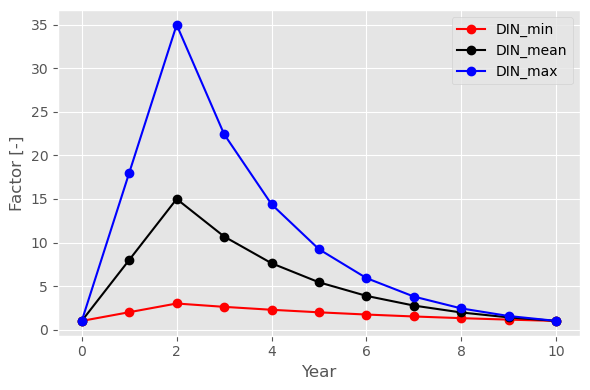

In [8]:
# Define harvesting effect parameters based on literature review
# values are (peak_factor, peak_year, effect_duration_years, plotting_style))
fac_dict = {
    "DIN_min": (3, 2, 10, "ro-"),
    "DIN_mean": (15, 2, 10, "ko-"),
    "DIN_max": (35, 2, 10, "bo-"),
}

# Plot
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
for par, (fac, pk_yr, eff_yrs, style) in fac_dict.items():
    xs, ys = fit_exponential(fac, eff_yrs, pk_yr)
    axes.plot(xs, ys, style, label=par)
    axes.set_ylabel("Factor [-]")
    axes.set_xlabel("Year")
    axes.legend(loc="best")
plt.tight_layout()

## 3. Get standard TEOTIL3 input data

TEOTIL3 already estimates "natural" losses from woodland using background coefficients based on the 2019 "1000 Lakes" survey. The notebook `1000_lakes_logging.ipynb` shows that around 80 of the "near-natural" 1000 Lakes catchments actually include some logging according to SR16beta. This is a fairly small proportion and I therefore do not think it is necessary to re-interpolate the background coefficients.

In [9]:
# Read standard TEOTIL input data
in_csv_path = os.path.join(
    teo_indata_fold,
    f"teotil3_input_data_nve{nve_data_year}_{mod_yr}.csv",
)
in_df = pd.read_csv(in_csv_path)

# Get cols relating to "standard" DIN from woodland
cols = ["regine", "runoff_mm/yr", "q_cat_m3/s", "wood_din_kg"]
wood_df = in_df[cols].copy()
wood_df.head()

,regine,runoff_mm/yr,q_cat_m3/s,wood_din_kg
0,001.10,448.0,0.016465,30.4
1,001.1A1,469.0,0.021273,51.6
2,001.1A20,449.0,0.004838,10.8
3,001.1A2A,482.0,0.269293,573.1
4,001.1A2B,482.0,0.630177,1108.8


In [10]:
# Get background woodland coeffs for regines
url = r"https://raw.githubusercontent.com/NIVANorge/teotil3/main/data/spatially_variable_background_coefficients.csv"
back_df = pd.read_csv(url)[["regine", "wood_din_µg/l"]]
back_df.head()

,regine,wood_din_µg/l
0,001.10,79.8
1,001.1A1,79.9
2,001.1A20,79.5
3,001.1A2A,79.1
4,001.1A2B,77.2


In [11]:
# Merge all relevant data
df = pd.merge(
    wood_df[["regine", "wood_din_kg", "runoff_mm/yr"]],
    reg_gdf[["regine", "a_wood_km2"]],
    how="left",
    on="regine",
)
df = pd.merge(df, back_df, how="left", on="regine")
df = pd.merge(df, har_df, how="left", on="regine")
df.fillna(0, inplace=True)

# Check that we can reproduce the original inputs to TEOTIL3 for this year
# (i.e. without harvesting)
new = (1e6 * df["a_wood_km2"] * df["runoff_mm/yr"] * df["wood_din_µg/l"] / 1e9).round(1)
orig = df["wood_din_kg"]
assert (new == orig).all()

## 4. Estimate effects of harvesting

In [12]:
stat = "mean"
fac, pk_yr, eff_yrs, _ = fac_dict[f"DIN_{stat}"]
xs, ys = fit_exponential(fac, eff_yrs, pk_yr, xmax=10)
f = interp1d(xs, ys)

# Only consider harvesting in years before the model year
har_yrs = [yr for yr in sr16_years if yr < mod_yr]
for year in har_yrs:
    yrs_ago = mod_yr - year
    fac = f(yrs_ago)
    assert fac >= 1
    df[f"harvesting_din_{year}_kg"] = (
        1e6
        * df[f"a_harvested_{year}_km2"]
        * df["runoff_mm/yr"]
        * df["wood_din_µg/l"]
        * (fac - 1)
        / 1e9
    )
cols = [f"harvesting_din_{year}_kg" for year in har_yrs]
df["harvesting_din_kg"] = df[cols].sum(axis="columns")
df.head()

/tmp/ipykernel_19368/1198416923.py:18: RuntimeWarning: overflow encountered in exp
  return A * np.exp(-B * (x - peak_year))
/tmp/ipykernel_19368/1198416923.py:25: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(exp_func, xs, ys)


,regine,wood_din_kg,runoff_mm/yr,a_wood_km2,wood_din_µg/l,a_harvested_2011_km2,a_harvested_2012_km2,a_harvested_2013_km2,a_harvested_2014_km2,a_harvested_2015_km2,...,harvesting_din_2012_kg,harvesting_din_2013_kg,harvesting_din_2014_kg,harvesting_din_2015_kg,harvesting_din_2016_kg,harvesting_din_2017_kg,harvesting_din_2018_kg,harvesting_din_2019_kg,harvesting_din_2020_kg,harvesting_din_kg
0,001.10,30.4,448.0,0.849188,79.8,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.121247,0.000000,0.000000,1.935104,2.056351
1,001.1A1,51.6,469.0,1.377476,79.9,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.595578,0.317724,0.000000,0.671724,10.398519,11.983544
2,001.1A20,10.8,449.0,0.303492,79.5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.283277,0.000000,0.283277
3,001.1A2A,573.1,482.0,15.030746,79.1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,29.554115,85.747206,166.028103,189.303699,91.461000,562.094123
4,001.1A2B,1108.8,482.0,29.798394,77.2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,34.932468,69.303506,148.895438,284.413550,97.706297,635.251259


## 5. Explore input data

In [13]:
# Add harvesting to input dataset
in_df = pd.merge(in_df, df[["regine", "harvesting_din_kg"]], how="left", on="regine")

wood_din_kg                      5.931608e+06
upland_din_kg                    4.836027e+06
urban_din_kg                     4.229221e+06
lake_din_kg                      3.017679e+06
spredt_din_kg                    2.182550e+06
aquaculture_din_kg               4.611639e+07
industry_din_kg                  1.254202e+06
large-wastewater_din_kg          1.246056e+07
agriculture_din_kg               3.620459e+07
agriculture-background_din_kg    4.022531e+06
harvesting_din_kg                8.798013e+05
dtype: float64


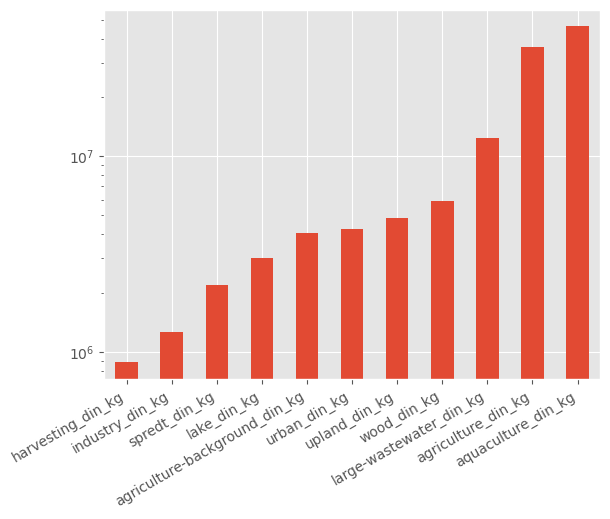

In [14]:
# Explore input data for DIN
# National totals
cols = [col for col in in_df.columns if col.endswith("din_kg")]
din_df = in_df[["regine"] + cols].set_index("regine")
nat_df = din_df.sum(axis="rows")
print(nat_df)
nat_df.sort_values().plot(kind="bar", logy=True)
plt.xticks(rotation=30, ha="right");

wood_din_kg                      9.913666e+05
upland_din_kg                    4.036325e+05
urban_din_kg                     8.424170e+05
lake_din_kg                      7.019511e+05
spredt_din_kg                    5.997950e+05
aquaculture_din_kg               0.000000e+00
industry_din_kg                  6.729610e+04
large-wastewater_din_kg          4.906009e+06
agriculture_din_kg               1.175315e+07
agriculture-background_din_kg    1.305905e+06
harvesting_din_kg                3.447983e+05
dtype: float64


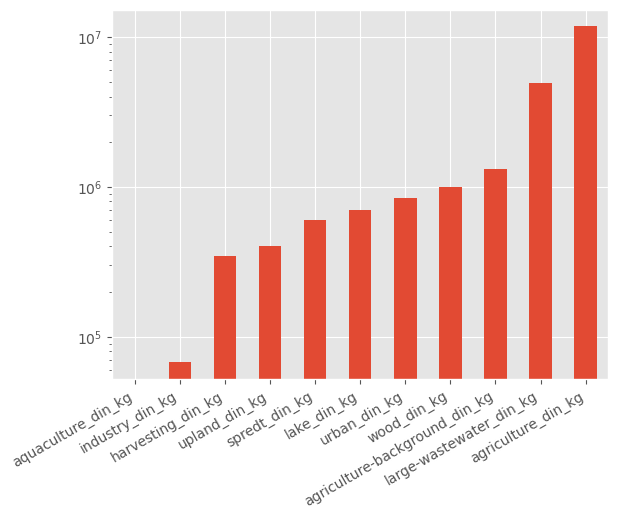

In [15]:
# Explore input data for DIN
# Whole Oslofjord
cols = [col for col in in_df.columns if col.endswith("din_kg")]
din_df = in_df[["regine"] + cols].set_index("regine")
vass_min, vass_max = 2, 14
vass_list = [f"{vass:03d}" for vass in range(vass_min, vass_max + 1)]
din_df["vassom"] = din_df.index.str.split(".").str[0]
din_df = din_df.query("vassom in @vass_list")
del din_df["vassom"]

osl_df = din_df.sum(axis="rows")
print(osl_df)
osl_df.sort_values().plot(kind="bar", logy=True)
plt.xticks(rotation=30, ha="right");

wood_din_kg                      6.588230e+04
upland_din_kg                    1.056800e+03
urban_din_kg                     2.079091e+05
lake_din_kg                      2.261190e+04
spredt_din_kg                    2.483990e+04
aquaculture_din_kg               0.000000e+00
industry_din_kg                  1.980000e+03
large-wastewater_din_kg          1.077169e+06
agriculture_din_kg               3.282286e+05
agriculture-background_din_kg    3.646984e+04
harvesting_din_kg                1.964240e+04
dtype: float64


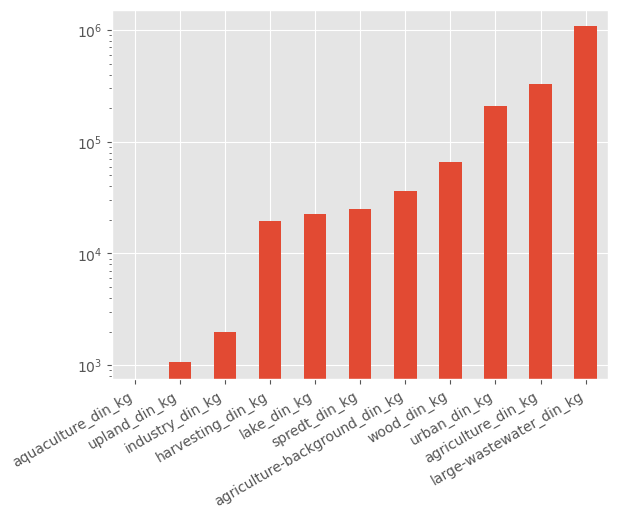

In [16]:
# Explore input data for DIN
# Inner Oslofjord
cols = [col for col in in_df.columns if col.endswith("din_kg")]
din_df = in_df[["regine"] + cols].set_index("regine")
vass_min, vass_max = 5, 9  # Inner Oslofjord
vass_list = [f"{vass:03d}" for vass in range(vass_min, vass_max + 1)]
din_df["vassom"] = din_df.index.str.split(".").str[0]
din_df = din_df.query("vassom in @vass_list")
del din_df["vassom"]

osl_df = din_df.sum(axis="rows")
print(osl_df)
osl_df.sort_values().plot(kind="bar", logy=True)
plt.xticks(rotation=30, ha="right");

In [17]:
# Find catchments where harvesting has a big effect on local inputs
# in Oslofjord area
cols = [col for col in in_df.columns if col.endswith("din_kg")]
din_df = in_df[["regine"] + cols].set_index("regine")
vass_min, vass_max = 2, 14
vass_list = [f"{vass:03d}" for vass in range(vass_min, vass_max + 1)]
din_df["vassom"] = din_df.index.str.split(".").str[0]
din_df = din_df.query("vassom in @vass_list")
del din_df["vassom"]

# First in "absolute" terms
din_df.sort_values("harvesting_din_kg", ascending=False).head()

,wood_din_kg,upland_din_kg,urban_din_kg,lake_din_kg,spredt_din_kg,aquaculture_din_kg,industry_din_kg,large-wastewater_din_kg,agriculture_din_kg,agriculture-background_din_kg,harvesting_din_kg
regine,,,,,,,,,,,
014.AZ,5582.8,51.9,5159.9,727.1,4844.8,0.0,0.0,11336.2,118920.889111,13213.432123,4395.300094
002.D3Z,3535.4,63.1,1164.9,807.8,3486.2,0.0,0.0,0.0,71721.470627,7969.052292,2946.425989
002.JAB,3874.5,213.8,315.2,171.0,1388.1,0.0,0.0,0.0,20100.530070,2233.392230,2687.439778
002.H3B,2739.8,140.8,1389.9,231.3,2714.1,0.0,0.0,532.2,45197.906501,5021.989611,2665.501745
002.D2Z,3264.6,89.4,4920.0,161.2,3735.5,0.0,0.0,533.2,261367.321908,29040.813545,2477.301715


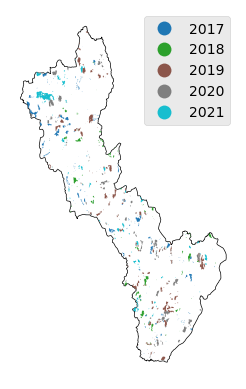

In [18]:
# Regine with the biggest "absolute" input from harvesting
reg_id = '014.AZ'
ax = reg_gdf.query("regine== @reg_id").plot(facecolor="none", edgecolor="black")
har_gdf.query("regine== @reg_id").plot(
    column="year", ax=ax, legend=True, categorical=True
)
ax.axis("off");

In [19]:
# Then in "percent" terms
din_df = 100 * din_df.div(din_df.sum(axis="columns"), axis="rows")
din_df.columns = [col.replace("kg", "pct") for col in din_df.columns]
din_df.sort_values("harvesting_din_pct", ascending=False).head()

,wood_din_pct,upland_din_pct,urban_din_pct,lake_din_pct,spredt_din_pct,aquaculture_din_pct,industry_din_pct,large-wastewater_din_pct,agriculture_din_pct,agriculture-bacpctround_din_pct,harvesting_din_pct
regine,,,,,,,,,,,
012.CB7B1,11.927692,0.000000,0.0,8.297525,0.0,0.0,0.0,0.0,0.0,0.0,79.774784
002.DC3CA,23.366334,0.533072,0.0,1.510371,0.0,0.0,0.0,0.0,0.0,0.0,74.590222
012.CC1AB,30.220103,4.258287,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,65.521610
002.DD5C,25.762951,0.000000,0.0,10.305180,0.0,0.0,0.0,0.0,0.0,0.0,63.931869
012.BB4A1A0,37.647176,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,62.352824


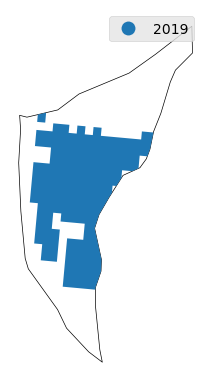

In [20]:
# Regine with the biggest "percentage" input from harvesting
reg_id = "012.CB7B1"
ax = reg_gdf.query("regine== @reg_id").plot(facecolor="none", edgecolor="black")
har_gdf.query("regine== @reg_id").plot(
    column="year", ax=ax, legend=True, categorical=True
)
ax.axis("off");

## 6. Run TEOTIL

In [21]:
# Run model
g = teo.model.run_model(
    in_df,
    id_col="regine",
    next_down_col="regine_down",
    totals_from_subfracs=True,
)
res_df = teo.model.model_to_dataframe(g, id_col="regine", next_down_col="regine_down")
res_df["year"] = mod_yr
res_df.head()

,regine,regine_down,accum_agriculture-background_din_kg,accum_agriculture-background_ss_kg,accum_agriculture-background_tdp_kg,accum_agriculture-background_toc_kg,accum_agriculture-background_ton_kg,accum_agriculture-background_totn_kg,accum_agriculture-background_totp_kg,accum_agriculture-background_tpp_kg,...,local_urban_tpp_kg,local_wood_din_kg,local_wood_ss_kg,local_wood_tdp_kg,local_wood_toc_kg,local_wood_ton_kg,local_wood_totn_kg,local_wood_totp_kg,local_wood_tpp_kg,year
0,001.10,001.,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,30.4,849.2,0.5,8369.6,156.8,187.2,4.6,4.1,2021
1,001.1A2B,001.1A2A,115.220464,0.593666,2.877428,5334.770318,63.808250,179.028715,3.036145,0.158717,...,4.7,1108.8,29798.4,20.1,323163.6,6005.1,7113.9,176.7,156.6,2021
2,001.1A4D,001.1A4C,14.953715,0.228242,0.098506,390.835334,6.322155,21.275869,0.125840,0.027334,...,0.0,199.5,5272.5,3.6,58885.5,1090.3,1289.8,32.1,28.5,2021
3,001.1M,001.1L,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,397.9,11104.0,7.4,120003.1,2220.1,2618.0,65.8,58.4,2021
4,001.21,001.,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,4.2,117.0,0.1,1166.3,21.8,26.0,0.7,0.6,2021


In [22]:
# Get accumulated DIN fluxes
cols = [col for col in res_df.columns if col.startswith("accum") and "_din_" in col]
df = res_df[["regine"] + cols].set_index("regine")
cols = [col.replace("accum_", "") for col in df.columns]
df.columns = cols

vass_min, vass_max = 2, 14
vass_list = [f"{vass:03d}." for vass in range(vass_min, vass_max + 1)]
df = df.query("regine in @vass_list").sort_index()
df

,agriculture-background_din_kg,agriculture_din_kg,aquaculture_din_kg,harvesting_din_kg,industry_din_kg,lake_din_kg,large-wastewater_din_kg,spredt_din_kg,upland_din_kg,urban_din_kg,wood_din_kg
regine,,,,,,,,,,,
002.,692337.451431,6.231037e+06,0.0,157694.413228,34220.618101,272920.813406,1.918296e+06,285373.775370,194969.936341,293513.660658,432743.946113
003.,38210.332572,3.438930e+05,0.0,4789.625916,0.000000,11286.341555,2.149007e+05,9977.001012,301.735341,22644.861704,11547.371378
004.,21103.369277,1.899303e+05,0.0,408.891149,0.000000,122.900000,1.250817e+05,10093.100000,71.900000,12190.500000,4417.600000
005.,12761.292712,1.148516e+05,0.0,1.084416,0.000000,2135.414057,5.227236e+04,12432.768414,65.678860,20068.644755,5924.216768
006.,1213.602392,1.092242e+04,0.0,2861.465371,0.000000,6012.165788,2.730373e+05,1114.978655,191.778699,68489.089945,11073.646241
007.,1703.617196,1.533255e+04,0.0,4466.782058,0.000000,2182.026234,1.423383e+01,1190.454537,195.311991,26973.191429,12795.565067
008.,6256.117092,5.630505e+04,0.0,4519.691093,0.000000,1251.874355,3.637000e+02,2189.393032,258.124716,50724.900355,13075.668105
009.,7307.358228,6.576622e+04,0.0,3153.573693,1980.000000,1575.396811,7.512257e+05,4981.242837,53.382328,24515.360049,7272.454713
010.,3207.295486,2.886566e+04,0.0,1229.719134,0.000000,1019.104651,7.691500e+03,2348.112649,10.725448,3376.431574,2843.603583


In [23]:
# Percentage contributions
pct_df = 100 * df.div(df.sum(axis="columns"), axis="rows")
pct_df.columns = [col.replace("kg", "pct") for col in pct_df.columns]
pct_df.sort_values("harvesting_din_pct", ascending=False)

,agriculture-bacpctround_din_pct,agriculture_din_pct,aquaculture_din_pct,harvesting_din_pct,industry_din_pct,lake_din_pct,large-wastewater_din_pct,spredt_din_pct,upland_din_pct,urban_din_pct,wood_din_pct
regine,,,,,,,,,,,
007.,2.626860,23.641744,0.0,6.887471,0.000000,3.364534,0.021948,1.835599,0.301158,41.590805,19.729881
008.,4.636066,41.724594,0.0,3.349296,0.000000,0.927696,0.269518,1.622439,0.191282,37.589447,9.689662
010.,6.339512,57.055607,0.0,2.430652,0.000000,2.014353,15.202951,4.641259,0.021200,6.673825,5.620642
011.,5.190377,46.713397,0.0,2.077817,0.000000,1.253124,27.614705,3.150586,0.072641,7.344361,6.582991
012.,5.402508,48.622568,0.0,1.829907,0.110639,5.163272,24.431449,3.523601,1.790514,3.647428,5.478115
002.,6.585469,59.269224,0.0,1.499979,0.325504,2.596005,18.246704,2.714457,1.854541,2.791883,4.116233
014.,8.291942,74.627482,0.0,1.124422,0.000000,0.209735,5.872073,2.514464,0.076866,5.435553,1.847463
006.,0.323699,2.913294,0.0,0.763227,0.000000,1.603601,72.826176,0.297394,0.051152,18.267825,2.953630
003.,5.811007,52.299059,0.0,0.728404,0.000000,1.716421,32.681989,1.517297,0.045888,3.443818,1.756118


(65384.44866500051, 388310.1382350002, 6513724.05311, 7000781.808690001)

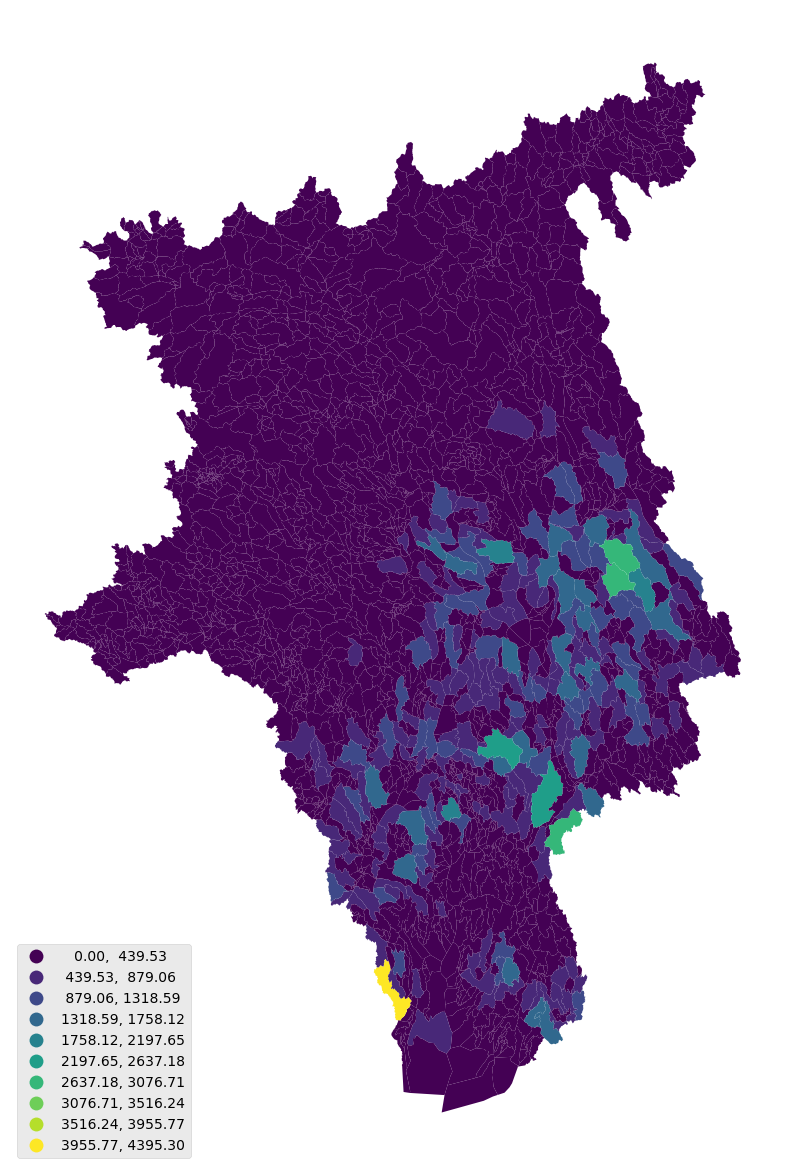

In [24]:
# Get local DIN fluxes
cols = [col for col in res_df.columns if col.startswith("local") and "_din_" in col]
osl_df = res_df[["regine"] + cols].set_index("regine")
cols = [col.replace("local_", "") for col in osl_df.columns]
osl_df.columns = cols

vass_min, vass_max = 2, 14
vass_list = [f"{vass:03d}" for vass in range(vass_min, vass_max + 1)]
osl_df["vassom"] = osl_df.index.str.split(".").str[0]
osl_df = osl_df.query("vassom in @vass_list").reset_index()
del osl_df["vassom"]
osl_gdf = reg_gdf.merge(
    osl_df[["regine", "harvesting_din_kg"]], how="left", on="regine"
)
osl_gdf.dropna(subset=["harvesting_din_kg"], inplace=True)
ax = osl_gdf.plot(
    column="harvesting_din_kg",
    edgecolor="none",
    legend=True,
    scheme="equalinterval",
    figsize=(15, 15),
    classification_kwds={"k": 10},
    legend_kwds={"loc": "lower left"},
)
ax.axis("off")